### Dataset Development (Market Data OHLCV + TA)

**OHLCV Data:**

- From Enfoque + Nelogica (2017/04 - 2022/07)
  - 1-min time-bars
    - Resampled to Daily and Hourly data


**Technical Indicators:**

- From `ta_lib`
  - SMAs
  - EMAs
  - RSI
  - ADX
  - MACD
  - BBANDS
  - OBV

In [276]:
import os
import numpy as np
import ta as ta_lib
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pd.options.mode.use_inf_as_na = True

# Quantstats
import quantstats as qs
qs.extend_pandas()

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [277]:
ticker = 'VALE3'

In [278]:
# Get Adjusted 1-min bars
df = pd.read_parquet(f'../../data/market/ohlcv_minute/{ticker}.parquet')
df

,open,high,low,close,qty,volume,status
symbol,VALE3,VALE3,VALE3,VALE3,VALE3,VALE3,VALE3
datetime,,,,,,,
2017-04-13 13:04:00+00:00,19.691847,19.691847,19.663079,19.691847,16300.0,3.208613e+05,0.0
2017-04-13 13:05:00+00:00,19.670271,19.691847,19.670271,19.677463,4100.0,8.067904e+04,0.0
2017-04-13 13:06:00+00:00,19.684655,19.684655,19.684655,19.684655,200.0,3.936931e+03,0.0
2017-04-13 13:07:00+00:00,19.756575,19.763767,19.677463,19.713423,4500.0,8.871112e+04,0.0
2017-04-13 13:08:00+00:00,19.727807,19.742191,19.713423,19.713423,2400.0,4.732948e+04,0.0
...,...,...,...,...,...,...,...
2022-07-15 19:51:00+00:00,68.220000,68.270000,68.210000,68.270000,154000.0,1.050844e+07,0.0
2022-07-15 19:52:00+00:00,68.240000,68.340000,68.230000,68.320000,253700.0,1.732780e+07,0.0


### Get OHLCV Bars from QFLib

**Output:**

- Daily OHLCV DataFrame
- Hourly OHLCV DataFrame

In [279]:
# Get Adjusted 1-min bars
df = pd.read_parquet(f'../../data/market/ohlcv_minute/{ticker}.parquet')

# Adjust Timestamp
df.index = df.index.tz_convert(None) - pd.Timedelta(hours=3)

# Filter Trading Hours (10h - 17h)
hours = df.index.hour
df = df.iloc[(hours >= 10) & (hours < 17)]

# Drop level (ticker)
df.columns = df.columns.droplevel(1)

# Drop volume
df = df.drop(columns=['volume'])

# Rename qty to volume
df = df.rename(columns={'open': 'Open', 
                        'high': 'High', 
                        'low': 'Low', 
                        'close': 'Close', 
                        'qty': 'Volume'})

# Rename index
df.index = df.index.rename('Date')

In [280]:
# Resample to Daily Bars

ohlcv_dict_daily = {                                                                                                             
    'Open': 'first',                                                                                                    
    'High': 'max',                                                                                                       
    'Low': 'min',                                                                                                        
    'Close': 'last',
    'Volume': 'sum'
}

df_daily = df.resample('1D', closed='left', label='left').apply(ohlcv_dict_daily).dropna()

# Resample to 1 Hour Bars
ohlcv_dict_hourly = {                                                                                                             
    'Open': 'first',                                                                                                    
    'High': 'max',                                                                                                       
    'Low': 'min',                                                                                                        
    'Close': 'last',
    'Volume': 'sum'
}

df_hourly = df.groupby(pd.Grouper(freq='1h')).agg(ohlcv_dict_hourly).dropna()

In [281]:
# Daily Bars
df_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-04-13,19.691847,20.065834,19.619926,19.792536,3604800.0
2017-04-17,19.598350,19.756575,19.188403,19.706231,4254800.0
2017-04-18,19.094906,19.245939,18.807224,19.159635,6581700.0
2017-04-19,19.346628,19.734999,19.087714,19.166827,5684400.0
2017-04-20,19.627118,20.209675,19.504853,20.144946,4201800.0


In [282]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1300 entries, 2017-04-13 to 2022-07-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1300 non-null   float64
 1   High    1300 non-null   float64
 2   Low     1300 non-null   float64
 3   Close   1300 non-null   float64
 4   Volume  1300 non-null   float64
dtypes: float64(5)
memory usage: 60.9 KB


In [283]:
# Hourly Bars
df_hourly.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-04-13 10:00:00,19.691847,19.936377,19.619926,19.929185,390500.0
2017-04-13 11:00:00,19.936377,20.065834,19.821304,20.008297,287800.0
2017-04-13 12:00:00,20.015489,20.058642,19.756575,19.814112,468900.0
2017-04-13 13:00:00,19.814112,19.979529,19.706231,19.900416,537400.0
2017-04-13 14:00:00,19.900416,19.907608,19.742191,19.756575,605400.0


In [284]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9070 entries, 2017-04-13 10:00:00 to 2022-07-15 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    9070 non-null   float64
 1   High    9070 non-null   float64
 2   Low     9070 non-null   float64
 3   Close   9070 non-null   float64
 4   Volume  9070 non-null   float64
dtypes: float64(5)
memory usage: 425.2 KB


In [285]:
assert df_daily.loc['2018-06-15'].Volume == df_hourly.loc['2018-06-15'].Volume.sum()

---

### Feature Engineering

In [286]:
def fix_dataset_inconsistencies(dataframe, fill_value=None):
    """
    TODO
    """
    
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = dataframe.iloc[0,:].fillna(fill_value)
        
    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    """
    Calculate RSI indicator.
    """
    
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    
    return 100 * (1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    """
    Calculate MACD indicator.
    """
    
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    """
    TODO
    """
    
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn'
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            indicator = qs.stats.__dict__[indicator_name](df['Close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            print (f'Error on indicator: {indicator_name}')
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    """TODO"""

    # Automatically-generated using 'ta_lib'
    df = data.copy()

    df.index = pd.DatetimeIndex(df.index)

    # Generate all default indicators from ta library
    ta_lib.add_all_ta_features(data, 
                            'Open', 
                            'High', 
                            'Low', 
                            'Close', 
                            'Volume', 
                            fillna=True)

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ema_5': ta_lib.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta_lib.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta_lib.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_14': rsi(data['Close'], period=14),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50)
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()
    
    # Revert naming convention
    data = data.rename(columns={'Date': 'date'})

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    
    data.set_index('date', inplace=True)
    
    return data

In [287]:
data_daily = generate_features(df_daily)
data_hourly = generate_features(df_hourly)

In [288]:
data_daily.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,Volume,compsum,implied_volatility,outliers,pct_rank,remove_outliers,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
date,,,,,,,,,,,,,,,,,,,,,
2018-02-06,30.229899,31.416410,30.073190,31.371636,17165600.0,1.874711e+08,417633800.0,0.001582,5.027132e+05,0.087590,...,17165600.0,5.950333e+280,0.302368,96.019256,78.333333,31.371636,2.440104,3.994687,0.270086,-0.032451
2018-02-07,31.662666,31.879074,31.170153,31.379098,16771200.0,1.805860e+08,434405000.0,-0.007481,4.487759e+05,3.296284,...,16771200.0,1.926664e+282,0.302368,96.019256,78.333333,31.379098,2.444348,4.001486,0.270075,-0.032221
2018-02-08,31.110454,31.438797,30.647790,31.050755,15803900.0,1.808842e+08,418601100.0,0.001019,-3.566338e+05,-2.409074,...,15803900.0,6.175104e+283,0.302368,96.019256,66.666667,31.050755,2.435029,3.984514,0.270181,-0.042348
2018-02-09,30.894047,31.640280,30.617940,30.991057,18326600.0,1.759347e+08,400274500.0,-0.035486,-4.619823e+05,0.478724,...,18326600.0,1.975481e+285,0.302368,96.019256,65.000000,30.991057,2.299559,3.752146,0.269449,-0.044189
2018-02-14,32.386513,33.162595,32.282040,33.087972,20648600.0,1.930835e+08,420923100.0,0.007973,5.789494e+06,6.794198,...,20648600.0,6.734014e+286,0.302368,96.019256,100.000000,33.087972,2.452462,4.184798,0.281782,0.000000


In [289]:
data_hourly.head(10)

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,Volume,compsum,implied_volatility,outliers,pct_rank,remove_outliers,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
date,,,,,,,,,,,,,,,,,,,,,
2017-05-26 14:00:00,20.558058,20.595033,20.513688,20.558058,184800.0,-5.502137e+06,14742200.0,0.043897,3749.771465,1.464798e+00,...,184800.0,1.831438e+265,0.152168,95.899467,81.666667,20.558058,0.028001,0.037622,0.157033,-0.026951
2017-05-26 15:00:00,20.572848,20.632008,20.550663,20.609823,232700.0,-5.396364e+06,14974900.0,0.023468,4934.902843,1.292531e+00,...,232700.0,3.957706e+266,0.152168,95.899467,86.666667,20.609823,0.092015,0.123687,0.157031,-0.024501
2017-05-26 16:00:00,20.609823,20.646798,20.535873,20.595033,555100.0,-5.359358e+06,14419800.0,0.049383,3057.072097,3.549666e-14,...,555100.0,8.546680e+267,0.152168,95.899467,85.000000,20.595033,0.087448,0.117547,0.157034,-0.025201
2017-05-29 10:00:00,20.395369,21.001757,20.395369,20.979573,208100.0,-5.166484e+06,14627900.0,0.114467,14052.149222,3.124528e+01,...,208100.0,1.878524e+269,0.152168,95.899467,100.000000,20.979573,0.628275,0.872655,0.155644,-0.007000
2017-05-29 11:00:00,20.979573,21.260582,20.949993,21.201422,1032200.0,-4.527503e+06,15660100.0,0.188800,44758.000237,1.223835e+01,...,1032200.0,4.170590e+270,0.152168,95.899467,100.000000,21.201422,0.948058,1.331816,0.154947,0.000000
2017-05-29 12:00:00,21.201422,21.201422,21.001757,21.009152,318300.0,-4.822226e+06,15341800.0,0.125837,29621.226334,-2.319379e-01,...,318300.0,9.179114e+271,0.152168,95.899467,98.333333,21.009152,0.891241,1.249320,0.155359,-0.009069
2017-05-29 13:00:00,21.009152,21.053522,20.920413,20.927808,292900.0,-5.082581e+06,15048900.0,0.106495,21985.922250,-5.209061e+00,...,292900.0,2.012779e+273,0.152168,95.899467,93.333333,20.927808,0.889626,1.247017,0.155366,-0.012905
2017-05-29 14:00:00,20.920413,20.986968,20.890833,20.898228,277500.0,-5.317389e+06,14771400.0,0.114476,17672.442874,-1.665207e+00,...,277500.0,4.407628e+274,0.152168,95.899467,91.666667,20.898228,0.920449,1.290704,0.155270,-0.014301
2017-05-29 15:00:00,20.890833,20.898228,20.787303,20.816883,328900.0,-5.470876e+06,14442500.0,0.070361,11325.762988,-3.242241e+00,...,328900.0,9.616071e+275,0.152168,95.899467,88.333333,20.816883,0.899064,1.260311,0.155347,-0.018137


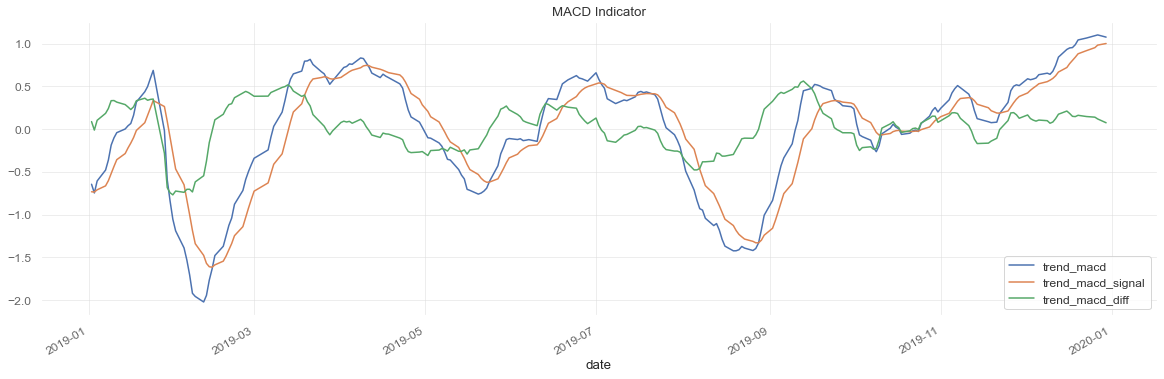

In [290]:
# BBANDS daily
data_daily[['trend_macd', 'trend_macd_signal', 'trend_macd_diff']].loc['2019'].plot(figsize=(20,6)).set_title('MACD Indicator');

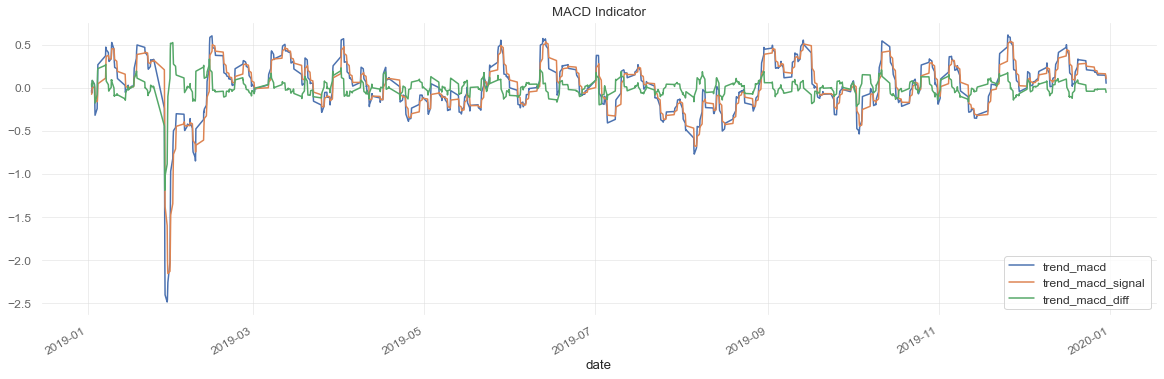

In [291]:
# BBANDS daily
data_hourly[['trend_macd', 'trend_macd_signal', 'trend_macd_diff']].loc['2019'].plot(figsize=(20,6)).set_title('MACD Indicator');

In [292]:
columns_to_keep = [
    # OHLCV
    'open',
    'high',
    'low',
    'close',
    'volume',
    'prev_open',
    'prev_high',
    'prev_low',
    'prev_close',
    'prev_volume',
    # Volume Indicators (OBV)
    'volume_obv',
    # Momentum Indicators (RSI)
    'momentum_rsi',
    # Strength Indicator (ADX, MACD)
    'trend_adx',
    'trend_macd',
    'trend_macd_signal',
    'trend_macd_diff',
    # Volatility Indicators (BBANDS)
    'volatility_bbm',
    'volatility_bbh',
    'volatility_bbl',
    # Custom Indicators
    'vol_5',
    'vol_10',
    'vol_20',
    'ma_5',
    'ma_10',
    'ma_20',
    'ema_5',
    'ema_10',
    'ema_20',
    'lr_open',
    'lr_high',
    'lr_low',
    'lr_close',
    'r_volume'
]

data_daily_final = data_daily[columns_to_keep]
data_hourly_final = data_hourly[columns_to_keep]

In [293]:
def generate_train_test_datasets(df, symbol, train_test_split, final_dir, save_csv=False):
    """
    Return Train/Test Splits from specific ticker from Qflib.
    """

    next_day = datetime.strptime(train_test_split, '%Y-%m-%d')
    next_day = next_day + timedelta(days=1)
    next_day = next_day.strftime('%Y-%m-%d')

    df_train = df.loc[:train_test_split].copy()
    df_test = df.loc[next_day:].copy()

    if save_csv:
        df_train.dropna().to_csv(f'../../data/market/{final_dir}/train/{symbol}_train.csv', index=True)
        df_test.dropna().to_csv(f'../../data/market/{final_dir}/test/{symbol}_test.csv', index=True)

    return df_train, df_test

#### Final OHLCV Daily Bars and TA

In [294]:
# Filter data since 2018
st_year = '2018'
data_daily_final = data_daily_final.loc[st_year:]
data_hourly_final = data_hourly_final.loc[st_year:]

In [295]:
train_test_split = '2022-01-01'
df_train, df_test = generate_train_test_datasets(data_daily_final, ticker, train_test_split, 'ohlcv_daily_TA', save_csv=True)
print ('Train: ', df_train.shape)
print ('Test: ', df_test.shape)

Train:  (965, 33)
Test:  (135, 33)


In [296]:
df_train, df_test = generate_train_test_datasets(data_hourly_final, ticker, train_test_split, 'ohlcv_hourly_TA', save_csv=True)
print ('Train: ', df_train.shape)
print ('Test: ', df_test.shape)

Train:  (6904, 33)
Test:  (934, 33)


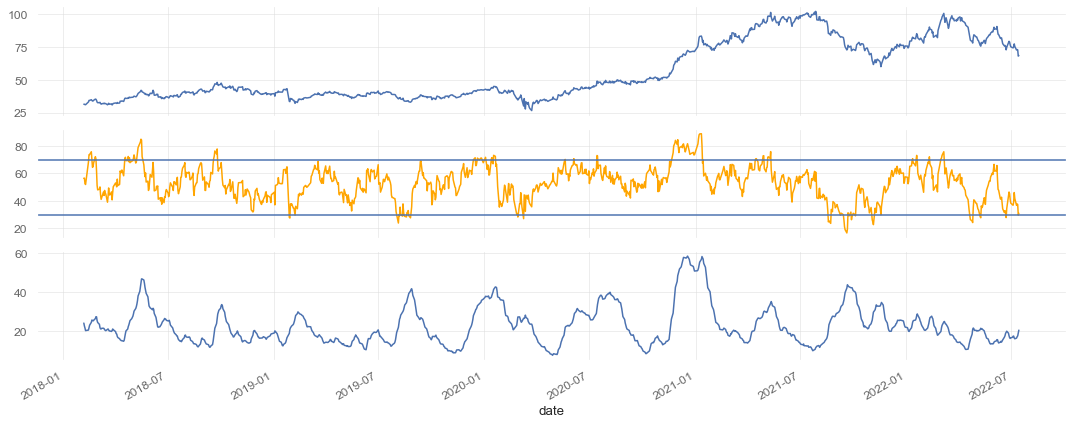

In [297]:
fig, ax = plt.subplots(3, sharex=True, figsize=(15,6))
data_daily_final.close.plot(ax=ax[0])

data_daily_final.momentum_rsi.plot(ax=ax[1], color='orange')
ax[1].axhline(30)
ax[1].axhline(70)
data_daily_final['trend_adx'].plot(ax=ax[2])

plt.tight_layout();

In [298]:
# 1. Hourly OHLCV
data_hourly_final_ohlcv = data_hourly_final[['open', 'high', 'low', 'close', 'volume']]

# 2. Daily OHLCV with Technical Indicators
data_daily_final_shifted = data_daily_final.shift().dropna()
data_daily_final_shifted = data_daily_final_shifted.rename(columns={'open': 'open_d', 'high': 'high_d', 'low': 'low_d', 'close': 'close_d', 'volume': 'volume_d'})

# 3. Merge Daily OHLCV with Technical Indicators with Hourly OHLCV
data_daily_hourly = pd.concat([data_hourly_final_ohlcv, data_daily_final_shifted], axis=1).ffill().dropna()

# Filter trading hours (if necessary)
hours = data_daily_hourly.index.hour
data_daily_hourly = data_daily_hourly.iloc[((hours > 10) & (hours <= 17))]

In [299]:
data_daily_hourly.head(5)

,open,high,low,close,volume,open_d,high_d,low_d,close_d,volume_d,...,ma_10,ma_20,ema_5,ema_10,ema_20,lr_open,lr_high,lr_low,lr_close,r_volume
date,,,,,,,,,,,,,,,,,,,,,
2018-02-07 11:00:00,31.535807,31.789526,31.498495,31.782064,2714600.0,30.229899,31.41641,30.07319,31.371636,17165600.0,...,31.035831,31.551851,31.138962,31.186817,31.055941,-0.001234,0.001426,-0.000744,0.014375,0.44774
2018-02-07 12:00:00,31.782064,31.879074,31.565656,31.811913,2456200.0,30.229899,31.41641,30.07319,31.371636,17165600.0,...,31.035831,31.551851,31.138962,31.186817,31.055941,-0.001234,0.001426,-0.000744,0.014375,0.44774
2018-02-07 13:00:00,31.811913,31.819375,31.498495,31.655204,2194200.0,30.229899,31.41641,30.07319,31.371636,17165600.0,...,31.035831,31.551851,31.138962,31.186817,31.055941,-0.001234,0.001426,-0.000744,0.014375,0.44774
2018-02-07 14:00:00,31.662666,31.811913,31.505958,31.573119,2137900.0,30.229899,31.41641,30.07319,31.371636,17165600.0,...,31.035831,31.551851,31.138962,31.186817,31.055941,-0.001234,0.001426,-0.000744,0.014375,0.44774
2018-02-07 15:00:00,31.573119,31.692516,31.297012,31.476108,2287300.0,30.229899,31.41641,30.07319,31.371636,17165600.0,...,31.035831,31.551851,31.138962,31.186817,31.055941,-0.001234,0.001426,-0.000744,0.014375,0.44774


In [300]:
df_train, df_test = generate_train_test_datasets(data_daily_hourly, ticker, train_test_split, 'ohlcv_daily_hourly_TA', save_csv=True)
print ('Train: ', df_train.shape)
print ('Test: ', df_test.shape)

Train:  (5771, 38)
Test:  (804, 38)


---

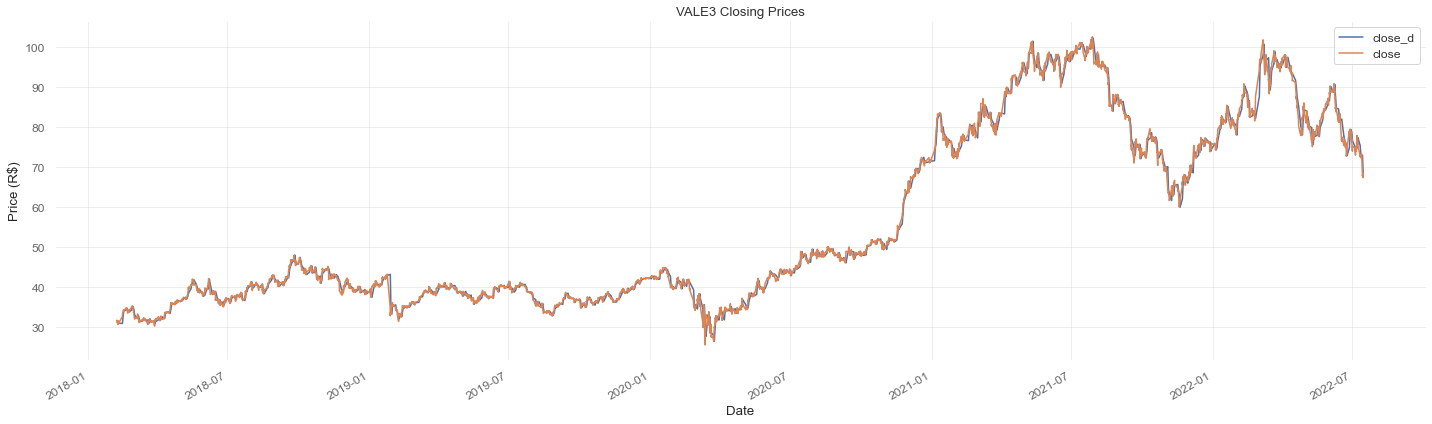

In [301]:
fig, ax = plt.subplots(figsize=(20,6))
data_daily_hourly.loc[st_year:].close_d.plot(ax=ax)
data_daily_hourly.loc[st_year:].close.plot(ax=ax)
ax.set_title(f'{ticker} Closing Prices')
ax.set_ylabel('Price (R$)')
ax.set_xlabel('Date')
plt.legend()
plt.tight_layout();

---